<a href="https://colab.research.google.com/github/ehddnr301/dacon_cv2/blob/master/nfnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Feb 21 13:46:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

os.listdir('/content/drive/MyDrive/dacon_computer_vision/')

['data',
 'Untitled1.ipynb',
 'model.h5',
 'eff_model.pt',
 'eff_model1.pt',
 'dacon-vision2.ipynb',
 'Untitled0.ipynb',
 'checkpoint',
 'dacon_cv.zip',
 'eff_model_cv2.pt',
 'Untitled3.ipynb',
 'Untitled2.ipynb',
 'dacon_cv2.ipynb',
 'eff_model_0214.pt',
 'resnet_model_0218.pt',
 'resnet152.ipynb',
 'dacon_cv2_resnet.ipynb',
 'ensemble.ipynb',
 'dacon_computervision2.ipynb']

In [ ]:
# !unzip -n '/content/drive/MyDrive/dacon_computer_vision/dacon_cv.zip' -d '/content/drive/MyDrive/dacon_computer_vision/data/'

In [ ]:
# colab 에서 자꾸 unzip한 이미지중에 일부가 없어져서 -n modifier를 주고 계속 실행하려함.
!unzip -n '/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist_2nd.zip' -d '/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist'

Archive:  /content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist_2nd.zip
error:  cannot create /content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist/00000.png
        Input/output error


In [ ]:
!pip install torchinfo

In [ ]:
import timm
from timm.utils.agc import adaptive_clip_grad

In [ ]:
import os
from typing import Tuple, Sequence, Callable
import csv
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary

import albumentations


from torchvision import transforms


In [ ]:
# random seed
random_seed = 301
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)


IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
EPOCHS=30

PATH_TRAIN_DATASET='/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist/'
PATH_TEST_DATASET='/content/drive/MyDrive/dacon_computer_vision/data/test_dirty_mnist/'
PATH_TRAIN_ANS_CSV='/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist_2nd_answer.csv'

In [ ]:
df = pd.read_csv(PATH_TRAIN_ANS_CSV)
df.head()

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,1,1
1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1
2,2,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0
3,3,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0
4,4,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.05, random_state=random_seed)

In [ ]:
train.head()

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
31245,31245,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0
35091,35091,0,1,1,0,0,1,1,1,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,1,0,1
9730,9730,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,1,1
28408,28408,0,1,1,0,0,0,1,1,0,1,1,1,0,1,1,0,0,1,0,1,1,0,0,0,0,1
43447,43447,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1


In [ ]:
PATH_TRAIN_CSV='/content/drive/MyDrive/dacon_computer_vision/data/mnist_train.csv'
PATH_VALID_CSV='/content/drive/MyDrive/dacon_computer_vision/data/mnist_valid.csv'


In [ ]:
train.to_csv(PATH_TRAIN_CSV, index=False)

In [ ]:
valid.to_csv(PATH_VALID_CSV, index=False)

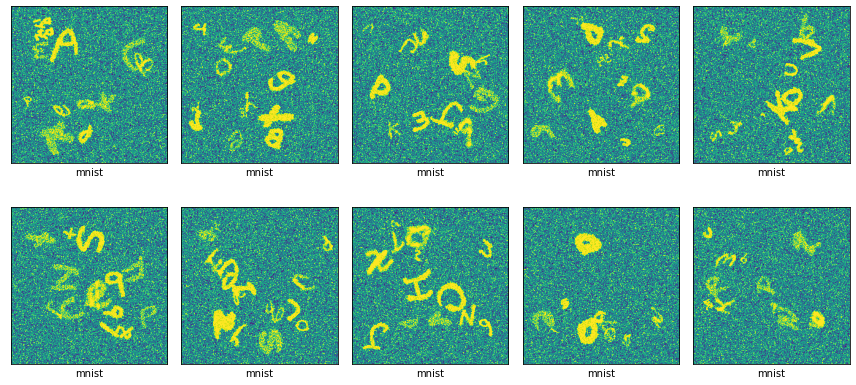

In [ ]:
import random
import matplotlib.pyplot as plt


plt.figure(figsize=(12,6))
mnist_sample = random.sample(os.listdir(PATH_TRAIN_DATASET), 10)

for i, image in enumerate(mnist_sample):
  path = os.path.join(PATH_TRAIN_DATASET, image)
  img = Image.open(path)
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.xlabel('mnist')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()


In [ ]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids: os.PathLike,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms

        self.labels = {}
        with open(image_ids, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                self.labels[int(row[0])] = list(map(int, row[1:]))

        self.image_ids = list(self.labels.keys())

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids[index]
        image = cv2.imread(
            os.path.join(
                self.dir, f'{str(image_id).zfill(5)}.png'))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = np.array(self.labels.get(image_id)).astype(np.float32)

        if self.transforms is not None:
            augmented = self.transforms(image=image) 
            image = augmented['image']

        return image, target

In [ ]:
from albumentations.pytorch import ToTensor

In [ ]:
transforms_train = albumentations.Compose([
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.VerticalFlip(p=1),
                          albumentations.RandomRotate90(p=0.5)
    ], p=0.8),
    albumentations.OneOf([
                          albumentations.RandomBrightness(limit=0.1, p=1),
                          albumentations.RandomContrast(limit=0.1, p=1),
    ], p=0.1),
    ToTensor((
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )),
])

transforms_valid = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    ToTensor((
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )),
])

transforms_test = albumentations.Compose([
    ToTensor((
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )),
])


# transforms_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=(180, 180)),
#     transforms.RandomAffine(5),
#     transforms.RandomGrayscale(p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         [0.485, 0.456, 0.406],
#         [0.229, 0.224, 0.225]
#     )
# ])

# transforms_valid = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         [0.485, 0.456, 0.406],
#         [0.229, 0.224, 0.225]
#     )
# ])

# transforms_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(
#         [0.485, 0.456, 0.406],
#         [0.229, 0.224, 0.225]
#     )
# ])

In [ ]:
trainset = MnistDataset(PATH_TRAIN_DATASET, PATH_TRAIN_CSV, transforms_train)
valset = MnistDataset(PATH_TRAIN_DATASET, PATH_VALID_CSV, transforms_valid)
testset = MnistDataset(PATH_TEST_DATASET, '/content/drive/MyDrive/dacon_computer_vision/data/sample_submission.csv', transforms_test)

train_loader = DataLoader(trainset, batch_size=32)
val_loader = DataLoader(valset, batch_size=32)
test_loader = DataLoader(testset, batch_size=16)

In [ ]:
# print(valset.labels)

In [ ]:
class NFNetModel(nn.Module):
    def __init__(self, num_classes=26, model_name='nfnet_f0', pretrained=True):
        super(NFNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.load_state_dict(torch.load("content/drive/MyDrive/dacon_computer_vision/NFNet-f0.pt"))
        self.model.head.fc = nn.Linear(self.model.head.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NFNetModel().to(device)
print(summary(model, input_size=(1, 3, 256, 256), verbose=0))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5
Layer (type:depth-idx)                                  Output Shape              Param #
├─EfficientNet: 1-1                                     [1, 1000]                 --
|    └─Conv2dStaticSamePadding: 2-1                     [1, 48, 128, 128]         --
|    |    └─ZeroPad2d: 3-1                              [1, 3, 258, 258]          --
|    └─BatchNorm2d: 2-2                                 [1, 48, 128, 128]         96
|    └─MemoryEfficientSwish: 2-3                        [1, 48, 128, 128]         --
|    └─ModuleList: 2                                    []                        --
|    |    └─MBConvBlock: 3-2                            [1, 24, 128, 128]         2,940
|    |    └─MBConvBlock: 3-3                            [1, 24, 128, 128]         1,206
|    |    └─MBConvBlock: 3-4                            [1, 24, 128, 128]         1,206
|    |    └─MBConvBlock: 3-5                            [1, 40, 64, 64]           13,046


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
criterion = nn.MultiLabelSoftMarginLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min',
                                                  factor=0.5,
                                                  patience=2,)



for epoch in range(EPOCHS):
    

    for i, (images, targets) in enumerate(train_loader):

        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        model.train()

        with torch.set_grad_enabled(True):
            outputs = model(images)
            loss = criterion(outputs, targets)

            loss.backward()
            adaptive_clip_grad(model.parameters(), clip_factor=0.01, eps=1e-3, norm_type=2.0)
            optimizer.step()

        if i % 50 == 0:
            outputs = outputs > 0.5
            acc = (outputs == targets).float().mean()
            print(f'{epoch+1}: {loss.item():.5f}, {acc.item():.5f}')


    valid_acc_list = []
    with tqdm(val_loader,
            total=val_loader.__len__(),
            unit="batch") as valid_bar:
        for i, (images, targets) in enumerate(valid_bar):
            valid_bar.set_description(f"Valid Epoch {epoch + 1}")
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)

            # 모델의 dropoupt, batchnormalization를 eval모드로 설정
            # .forward()에서 중간 노드의 gradient를 계산

            model.eval()

            with torch.no_grad():
                # validation loss만을 계산
                probs  = model(images)
                valid_loss = criterion(probs, targets)


                # train accuracy 계산
                probs  = probs.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                preds = probs > 0.5
                batch_acc = (targets == preds).mean()
                valid_acc_list.append(batch_acc)

            valid_acc = np.mean(valid_acc_list)
            valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                  valid_acc = valid_acc)

    scheduler.step(valid_loss)


    if (epoch + 1) % 5 == 0:
        torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f'/content/drive/MyDrive/dacon_computer_vision/checkpoint/model_0221_{epoch + 1}.pt')
    
    print('------------------')

1: 0.71798, 0.55409
1: 0.68546, 0.56010
1: 0.69375, 0.53486
1: 0.68190, 0.55529
1: 0.68033, 0.56731
1: 0.67659, 0.57091
1: 0.66205, 0.58894
1: 0.67255, 0.55889
1: 0.66523, 0.57692
1: 0.65299, 0.59014
1: 0.66559, 0.58173
1: 0.64920, 0.59255
1: 0.65877, 0.56731
1: 0.65155, 0.57692
1: 0.65104, 0.59255
1: 0.64336, 0.60697
1: 0.63957, 0.61058
1: 0.61900, 0.62500
1: 0.63503, 0.63702
1: 0.62556, 0.61298
1: 0.62401, 0.63462
1: 0.62489, 0.61659
1: 0.60511, 0.64543
1: 0.62532, 0.63702
1: 0.61341, 0.63702
1: 0.60840, 0.62620
1: 0.61280, 0.64183
1: 0.63027, 0.61298
1: 0.59596, 0.66466
1: 0.56755, 0.68510


Valid Epoch 1: 100%|██████████| 79/79 [21:29<00:00, 16.32s/batch, valid_acc=0.633, valid_loss=0.714]


------------------
2: 0.59095, 0.66707
2: 0.59231, 0.65505
2: 0.58497, 0.66947
2: 0.56938, 0.68029
2: 0.61465, 0.66226
2: 0.57942, 0.69591
2: 0.58898, 0.68149
2: 0.56161, 0.67788
2: 0.55300, 0.70793
2: 0.58328, 0.67308
2: 0.55389, 0.71394
2: 0.52890, 0.71154
2: 0.58156, 0.67909
2: 0.58467, 0.68630
2: 0.54476, 0.70072
2: 0.56455, 0.68870
2: 0.54309, 0.71755
2: 0.51249, 0.73077
2: 0.50225, 0.73438
2: 0.55476, 0.70312
2: 0.53229, 0.72115
2: 0.49307, 0.75120
2: 0.52929, 0.73197
2: 0.57219, 0.69351
2: 0.50287, 0.74399
2: 0.53444, 0.71394
2: 0.51760, 0.71514
2: 0.53172, 0.73438
2: 0.50384, 0.73438
2: 0.49660, 0.73918


Valid Epoch 2: 100%|██████████| 79/79 [00:27<00:00,  2.90batch/s, valid_acc=0.741, valid_loss=0.522]


------------------
3: 0.46781, 0.76202
3: 0.49390, 0.76322
3: 0.49151, 0.76442
3: 0.49586, 0.76202
3: 0.53215, 0.73798
3: 0.48895, 0.77284
3: 0.46302, 0.79087
3: 0.46322, 0.77524
3: 0.48320, 0.76803
3: 0.48626, 0.74519
3: 0.48118, 0.76202
3: 0.44263, 0.79327
3: 0.49495, 0.73918
3: 0.51687, 0.74639
3: 0.44670, 0.79207
3: 0.49817, 0.76082
3: 0.47449, 0.78245
3: 0.42774, 0.78726
3: 0.39913, 0.81490
3: 0.45721, 0.78726
3: 0.45056, 0.77764
3: 0.42839, 0.78486
3: 0.44848, 0.79207
3: 0.45898, 0.78606
3: 0.43552, 0.80409
3: 0.48012, 0.75361
3: 0.42789, 0.80649
3: 0.43950, 0.78486
3: 0.42704, 0.80649
3: 0.40789, 0.80529


Valid Epoch 3: 100%|██████████| 79/79 [00:26<00:00,  2.96batch/s, valid_acc=0.789, valid_loss=0.417]


------------------
4: 0.39486, 0.82212
4: 0.37535, 0.83774
4: 0.41776, 0.80769
4: 0.40151, 0.82813
4: 0.44720, 0.78245
4: 0.42475, 0.80529
4: 0.39899, 0.81250
4: 0.38589, 0.82212
4: 0.44813, 0.78966
4: 0.42885, 0.79808
4: 0.40812, 0.80048
4: 0.35750, 0.85457
4: 0.41716, 0.79688
4: 0.46180, 0.75721
4: 0.39610, 0.81490
4: 0.44237, 0.80288
4: 0.39368, 0.82692
4: 0.37336, 0.82091
4: 0.34944, 0.85096
4: 0.38804, 0.82212
4: 0.41923, 0.80168
4: 0.38320, 0.82332
4: 0.41417, 0.80529
4: 0.41100, 0.81851
4: 0.37515, 0.82813
4: 0.40215, 0.81490
4: 0.36725, 0.83534
4: 0.40168, 0.81490
4: 0.36075, 0.84255
4: 0.35935, 0.85216


Valid Epoch 4: 100%|██████████| 79/79 [00:27<00:00,  2.88batch/s, valid_acc=0.817, valid_loss=0.429]


------------------
5: 0.35770, 0.84615
5: 0.31722, 0.86058
5: 0.40784, 0.79928
5: 0.37496, 0.83413
5: 0.40016, 0.81130
5: 0.39573, 0.82692
5: 0.35706, 0.85697
5: 0.37619, 0.82692
5: 0.37472, 0.84495
5: 0.37268, 0.81971
5: 0.37052, 0.83413
5: 0.34349, 0.85697
5: 0.36650, 0.82813
5: 0.38087, 0.84014
5: 0.38723, 0.83173
5: 0.41236, 0.82692
5: 0.37634, 0.84375
5: 0.31718, 0.87260
5: 0.30926, 0.85817
5: 0.36914, 0.82933
5: 0.36806, 0.84255
5: 0.33923, 0.85216
5: 0.35699, 0.84856
5: 0.37201, 0.84615
5: 0.33125, 0.85577
5: 0.38594, 0.81731
5: 0.32887, 0.85577
5: 0.34689, 0.84495
5: 0.33436, 0.83894
5: 0.32053, 0.87139


Valid Epoch 5: 100%|██████████| 79/79 [00:26<00:00,  3.04batch/s, valid_acc=0.836, valid_loss=0.344]


------------------
6: 0.31386, 0.85938
6: 0.29801, 0.86659
6: 0.34047, 0.85817
6: 0.34238, 0.85337
6: 0.35483, 0.84255
6: 0.35305, 0.83894
6: 0.32285, 0.86418
6: 0.31042, 0.85817
6: 0.35781, 0.84736
6: 0.33160, 0.84255
6: 0.30200, 0.85938
6: 0.30643, 0.87260
6: 0.32163, 0.85457
6: 0.38101, 0.83293
6: 0.31614, 0.85938
6: 0.37860, 0.84495
6: 0.33622, 0.85817
6: 0.30781, 0.85577
6: 0.27183, 0.88822
6: 0.33501, 0.86899
6: 0.30098, 0.87139
6: 0.32130, 0.85697
6: 0.28912, 0.87380
6: 0.36202, 0.84976
6: 0.32150, 0.85817
6: 0.31857, 0.86418
6: 0.31664, 0.86178
6: 0.32645, 0.87260
6: 0.30577, 0.87500
6: 0.27431, 0.89904


Valid Epoch 6: 100%|██████████| 79/79 [00:25<00:00,  3.06batch/s, valid_acc=0.861, valid_loss=0.376]


------------------
7: 0.28671, 0.87740
7: 0.24829, 0.89663
7: 0.28750, 0.86779
7: 0.30000, 0.87380
7: 0.34655, 0.84495
7: 0.31810, 0.87139
7: 0.31723, 0.86779
7: 0.30554, 0.86899
7: 0.29128, 0.88101
7: 0.32837, 0.85337
7: 0.30839, 0.86178
7: 0.25926, 0.89663
7: 0.32588, 0.86779
7: 0.32043, 0.85216
7: 0.31716, 0.87139
7: 0.31954, 0.87380
7: 0.31374, 0.86779
7: 0.30316, 0.87500
7: 0.23793, 0.89663
7: 0.31055, 0.85817
7: 0.28516, 0.88942
7: 0.28347, 0.87380
7: 0.28046, 0.88341
7: 0.34217, 0.85938
7: 0.26656, 0.88942
7: 0.32636, 0.85938
7: 0.29985, 0.85697
7: 0.27893, 0.89183
7: 0.27321, 0.89183
7: 0.25524, 0.89183


Valid Epoch 7: 100%|██████████| 79/79 [00:27<00:00,  2.86batch/s, valid_acc=0.869, valid_loss=0.344]


------------------
8: 0.25375, 0.89303
8: 0.23706, 0.90625
8: 0.28098, 0.88101
8: 0.29652, 0.87260
8: 0.30264, 0.88101
8: 0.29054, 0.88702
8: 0.29081, 0.87500
8: 0.27280, 0.88702
8: 0.25556, 0.89663
8: 0.29768, 0.86418
8: 0.26261, 0.87500
8: 0.24922, 0.90024
8: 0.27136, 0.87620
8: 0.31267, 0.86418
8: 0.27877, 0.88942
8: 0.32701, 0.87620
8: 0.31379, 0.86899
8: 0.26827, 0.88702
8: 0.24955, 0.89183
8: 0.25943, 0.89183
8: 0.27196, 0.87620
8: 0.29022, 0.88582
8: 0.22839, 0.90625
8: 0.27083, 0.89543
8: 0.30609, 0.87500
8: 0.27268, 0.88341
8: 0.28009, 0.87981
8: 0.28539, 0.89183
8: 0.26797, 0.88702
8: 0.21612, 0.91827


Valid Epoch 8: 100%|██████████| 79/79 [00:27<00:00,  2.86batch/s, valid_acc=0.875, valid_loss=0.213]


------------------
9: 0.23741, 0.90865
9: 0.23448, 0.90385
9: 0.24875, 0.89543
9: 0.27307, 0.88341
9: 0.26734, 0.89303
9: 0.26903, 0.89784
9: 0.25391, 0.89543
9: 0.24473, 0.90144
9: 0.27332, 0.88462
9: 0.26432, 0.88942
9: 0.26926, 0.88582
9: 0.20778, 0.92067
9: 0.24002, 0.89303
9: 0.30700, 0.86538
9: 0.24724, 0.90144
9: 0.29865, 0.87740
9: 0.25846, 0.89183
9: 0.22228, 0.90865
9: 0.22099, 0.91587
9: 0.27666, 0.88101
9: 0.29758, 0.88462
9: 0.23461, 0.90024
9: 0.20148, 0.91947
9: 0.25915, 0.89663
9: 0.26203, 0.89303
9: 0.27527, 0.88582
9: 0.25391, 0.89303
9: 0.24494, 0.90745
9: 0.25019, 0.90865
9: 0.21041, 0.91346


Valid Epoch 9: 100%|██████████| 79/79 [00:27<00:00,  2.84batch/s, valid_acc=0.879, valid_loss=0.427]


------------------
10: 0.21473, 0.91587
10: 0.19940, 0.91827
10: 0.23373, 0.89904
10: 0.25061, 0.90385
10: 0.22929, 0.90144
10: 0.21938, 0.91346
10: 0.24656, 0.89904
10: 0.24754, 0.90024
10: 0.25941, 0.90505
10: 0.27819, 0.88101
10: 0.22478, 0.89663
10: 0.18730, 0.93029
10: 0.25238, 0.89784
10: 0.27680, 0.87620
10: 0.25557, 0.89784
10: 0.27790, 0.88702
10: 0.25814, 0.88101
10: 0.24898, 0.90264
10: 0.19323, 0.92188
10: 0.23383, 0.90264
10: 0.25803, 0.89303
10: 0.25744, 0.89543
10: 0.22081, 0.91466
10: 0.26271, 0.89784
10: 0.18351, 0.93029
10: 0.27445, 0.88822
10: 0.24055, 0.90385
10: 0.23726, 0.89784
10: 0.19787, 0.91947
10: 0.20022, 0.91947


Valid Epoch 10: 100%|██████████| 79/79 [00:27<00:00,  2.87batch/s, valid_acc=0.886, valid_loss=0.27]


------------------
11: 0.20315, 0.91707
11: 0.16899, 0.93029
11: 0.21650, 0.90625
11: 0.21318, 0.92067
11: 0.25511, 0.88822
11: 0.23210, 0.91466
11: 0.21192, 0.91587
11: 0.24041, 0.89904
11: 0.24305, 0.90264
11: 0.23484, 0.89784
11: 0.22342, 0.91346
11: 0.18358, 0.92909
11: 0.23039, 0.90625
11: 0.26980, 0.88582
11: 0.23211, 0.90986
11: 0.25849, 0.90625
11: 0.23301, 0.91106
11: 0.21189, 0.92067
11: 0.21056, 0.91947
11: 0.24001, 0.90024
11: 0.26763, 0.89904
11: 0.22273, 0.89904
11: 0.18395, 0.92909
11: 0.23039, 0.90144
11: 0.21264, 0.90505
11: 0.26462, 0.89663
11: 0.22180, 0.89784
11: 0.22326, 0.90625
11: 0.22491, 0.90745
11: 0.17834, 0.92909


Valid Epoch 11: 100%|██████████| 79/79 [00:27<00:00,  2.85batch/s, valid_acc=0.895, valid_loss=0.238]


------------------
12: 0.19573, 0.92428
12: 0.15753, 0.94952
12: 0.18400, 0.93149
12: 0.17278, 0.93149
12: 0.17647, 0.93510
12: 0.17534, 0.93630
12: 0.17438, 0.92909
12: 0.19658, 0.92188
12: 0.20202, 0.92308
12: 0.19494, 0.91947
12: 0.19096, 0.92428
12: 0.14010, 0.94712
12: 0.18901, 0.92909
12: 0.21335, 0.90865
12: 0.19483, 0.92067
12: 0.18537, 0.93269
12: 0.16972, 0.92909
12: 0.20621, 0.91466
12: 0.13730, 0.94712
12: 0.17354, 0.92067
12: 0.20064, 0.92668
12: 0.14884, 0.94471
12: 0.15602, 0.93870
12: 0.20169, 0.92668
12: 0.14982, 0.94471
12: 0.16704, 0.93149
12: 0.18953, 0.92548
12: 0.16681, 0.93269
12: 0.16847, 0.93269
12: 0.13755, 0.94591


Valid Epoch 12: 100%|██████████| 79/79 [00:27<00:00,  2.90batch/s, valid_acc=0.913, valid_loss=0.234]


------------------
13: 0.14513, 0.94471
13: 0.12903, 0.95192
13: 0.15414, 0.93510
13: 0.16122, 0.93870
13: 0.16393, 0.92788
13: 0.16744, 0.93389
13: 0.18050, 0.93149
13: 0.18178, 0.93029
13: 0.19642, 0.92788
13: 0.17157, 0.93149
13: 0.16769, 0.93029
13: 0.14857, 0.94712
13: 0.15594, 0.94351
13: 0.19644, 0.92308
13: 0.18931, 0.93149
13: 0.18137, 0.93149
13: 0.15768, 0.94111
13: 0.15662, 0.95313
13: 0.12665, 0.94952
13: 0.16011, 0.93750
13: 0.18252, 0.92788
13: 0.15000, 0.94231
13: 0.14474, 0.94351
13: 0.15559, 0.94351
13: 0.16358, 0.93149
13: 0.15345, 0.93389
13: 0.17521, 0.93149
13: 0.16095, 0.93149
13: 0.16054, 0.94351
13: 0.14496, 0.94832


Valid Epoch 13: 100%|██████████| 79/79 [00:26<00:00,  2.95batch/s, valid_acc=0.914, valid_loss=0.235]


------------------
14: 0.13889, 0.94832
14: 0.11004, 0.95793
14: 0.14573, 0.94351
14: 0.15950, 0.94111
14: 0.17207, 0.93029
14: 0.15793, 0.94591
14: 0.15519, 0.93990
14: 0.16040, 0.93750
14: 0.15597, 0.94351
14: 0.14751, 0.94712
14: 0.13874, 0.93990
14: 0.15244, 0.94111
14: 0.16070, 0.93990
14: 0.15131, 0.94591
14: 0.17360, 0.93750
14: 0.14120, 0.94952
14: 0.14376, 0.94111
14: 0.16432, 0.93750
14: 0.10264, 0.96755
14: 0.15397, 0.94111
14: 0.18490, 0.92548
14: 0.12743, 0.95313
14: 0.15862, 0.94231
14: 0.16149, 0.94111
14: 0.12956, 0.95313
14: 0.17357, 0.93750
14: 0.16118, 0.93990
14: 0.16007, 0.94591
14: 0.13533, 0.94591
14: 0.12961, 0.95673


Valid Epoch 14: 100%|██████████| 79/79 [00:27<00:00,  2.91batch/s, valid_acc=0.918, valid_loss=0.397]


------------------
15: 0.13101, 0.95072
15: 0.09865, 0.97476
15: 0.11583, 0.95313
15: 0.13808, 0.94591
15: 0.15409, 0.93990
15: 0.16882, 0.93630
15: 0.13513, 0.94832
15: 0.10234, 0.95433
15: 0.13764, 0.94591
15: 0.14193, 0.93990
15: 0.13446, 0.94591
15: 0.11963, 0.95072
15: 0.11975, 0.95192
15: 0.17253, 0.93389
15: 0.14640, 0.94591
15: 0.13637, 0.94832
15: 0.12099, 0.96034
15: 0.12354, 0.95673
15: 0.09770, 0.95793
15: 0.13060, 0.94832
15: 0.14486, 0.94712
15: 0.08610, 0.96394
15: 0.10300, 0.96635
15: 0.13626, 0.95313
15: 0.10508, 0.95913
15: 0.13377, 0.94712
15: 0.12216, 0.95313
15: 0.11376, 0.96034
15: 0.11419, 0.95913
15: 0.09665, 0.97115


Valid Epoch 15: 100%|██████████| 79/79 [00:26<00:00,  3.03batch/s, valid_acc=0.925, valid_loss=0.273]


------------------
16: 0.13646, 0.95433
16: 0.09368, 0.96755
16: 0.10566, 0.95553
16: 0.11162, 0.95793
16: 0.13791, 0.95553
16: 0.11165, 0.95913
16: 0.09930, 0.95673
16: 0.12421, 0.95433
16: 0.12277, 0.95673
16: 0.13250, 0.94952
16: 0.13846, 0.94712
16: 0.07582, 0.97236
16: 0.12260, 0.95313
16: 0.12534, 0.95673
16: 0.13641, 0.94471
16: 0.12674, 0.95673
16: 0.09639, 0.96274
16: 0.11987, 0.95553
16: 0.12752, 0.94591
16: 0.10066, 0.96514
16: 0.15044, 0.94351
16: 0.09067, 0.96394
16: 0.09626, 0.95913
16: 0.08440, 0.96635
16: 0.11011, 0.96755
16: 0.07703, 0.97356
16: 0.11550, 0.95313
16: 0.11553, 0.94952
16: 0.09172, 0.96635
16: 0.08194, 0.97356


Valid Epoch 16: 100%|██████████| 79/79 [00:27<00:00,  2.91batch/s, valid_acc=0.928, valid_loss=0.217]


------------------
17: 0.10724, 0.96394
17: 0.06914, 0.97716
17: 0.09186, 0.96154
17: 0.10511, 0.96154
17: 0.11603, 0.95673
17: 0.11244, 0.95553
17: 0.10062, 0.95913
17: 0.10575, 0.95192
17: 0.10293, 0.96034
17: 0.11511, 0.95913
17: 0.11043, 0.95913
17: 0.09207, 0.96875
17: 0.12149, 0.95553
17: 0.15809, 0.93269
17: 0.13268, 0.95192
17: 0.11735, 0.95433
17: 0.07959, 0.97837
17: 0.15147, 0.94591
17: 0.10348, 0.96274
17: 0.10326, 0.95793
17: 0.12735, 0.95913
17: 0.08393, 0.96875
17: 0.06996, 0.97356
17: 0.09912, 0.96635
17: 0.08896, 0.96755
17: 0.09138, 0.96875
17: 0.10493, 0.95673
17: 0.11154, 0.95913
17: 0.10770, 0.95673
17: 0.07805, 0.97596


Valid Epoch 17: 100%|██████████| 79/79 [00:27<00:00,  2.92batch/s, valid_acc=0.925, valid_loss=0.271]


------------------
18: 0.09613, 0.96274
18: 0.05994, 0.98197
18: 0.07215, 0.97356
18: 0.11139, 0.95192
18: 0.12661, 0.95913
18: 0.09303, 0.95913
18: 0.09291, 0.96875
18: 0.07159, 0.97476
18: 0.11029, 0.96274
18: 0.10059, 0.95913
18: 0.07946, 0.97236
18: 0.05892, 0.97957
18: 0.10767, 0.96034
18: 0.10614, 0.96034
18: 0.13145, 0.94952
18: 0.07476, 0.96995
18: 0.09070, 0.96995
18: 0.08435, 0.97356
18: 0.10132, 0.95793
18: 0.08290, 0.96875
18: 0.12340, 0.95192
18: 0.05626, 0.97596
18: 0.06951, 0.97476
18: 0.08911, 0.97115
18: 0.07361, 0.97356
18: 0.09403, 0.96635
18: 0.05940, 0.97957
18: 0.07889, 0.97115
18: 0.08371, 0.97236
18: 0.07832, 0.97476


Valid Epoch 18: 100%|██████████| 79/79 [00:26<00:00,  2.93batch/s, valid_acc=0.93, valid_loss=0.212]


------------------
19: 0.08801, 0.96394
19: 0.06939, 0.97236
19: 0.06676, 0.97476
19: 0.07825, 0.97236
19: 0.10360, 0.96394
19: 0.08780, 0.96635
19: 0.07185, 0.97476
19: 0.08184, 0.96274
19: 0.10716, 0.96514
19: 0.10845, 0.96394
19: 0.09638, 0.96154
19: 0.07448, 0.97115
19: 0.07960, 0.96394
19: 0.09336, 0.96514
19: 0.11165, 0.95913
19: 0.08623, 0.96755
19: 0.06618, 0.97236
19: 0.10033, 0.96875
19: 0.06394, 0.97596
19: 0.10485, 0.96875
19: 0.13088, 0.95313
19: 0.07007, 0.97115
19: 0.07723, 0.96995
19: 0.06103, 0.98077
19: 0.05643, 0.98197
19: 0.08591, 0.97356
19: 0.06339, 0.97596
19: 0.06950, 0.97837
19: 0.08224, 0.97596
19: 0.06752, 0.98077


Valid Epoch 19: 100%|██████████| 79/79 [00:27<00:00,  2.88batch/s, valid_acc=0.93, valid_loss=0.18]


------------------
20: 0.08459, 0.96875
20: 0.04740, 0.98197
20: 0.06094, 0.97837
20: 0.06890, 0.98197
20: 0.07821, 0.97236
20: 0.07663, 0.97476
20: 0.04033, 0.98798
20: 0.08170, 0.96514
20: 0.08890, 0.96875
20: 0.07091, 0.97476
20: 0.09333, 0.97115
20: 0.06256, 0.97957
20: 0.08726, 0.97476
20: 0.09281, 0.95913
20: 0.09424, 0.96635
20: 0.07891, 0.96514
20: 0.07607, 0.97596
20: 0.08741, 0.96755
20: 0.07270, 0.97476
20: 0.08501, 0.96755
20: 0.09305, 0.96875
20: 0.06953, 0.97356
20: 0.08143, 0.97716
20: 0.05913, 0.97716
20: 0.06705, 0.97476
20: 0.07528, 0.97115
20: 0.07130, 0.97356
20: 0.07268, 0.97476
20: 0.09133, 0.96755
20: 0.05300, 0.98077


Valid Epoch 20: 100%|██████████| 79/79 [00:27<00:00,  2.90batch/s, valid_acc=0.929, valid_loss=0.219]


------------------
21: 0.06607, 0.97476
21: 0.05332, 0.97957
21: 0.08324, 0.97115
21: 0.07856, 0.96995
21: 0.07229, 0.96995
21: 0.08799, 0.96755
21: 0.05100, 0.98438
21: 0.06567, 0.97236
21: 0.07206, 0.97957
21: 0.08221, 0.96875
21: 0.06529, 0.97596
21: 0.04944, 0.98918
21: 0.09275, 0.95313
21: 0.06837, 0.97837
21: 0.12572, 0.96034
21: 0.07511, 0.97236
21: 0.05604, 0.98438
21: 0.06965, 0.98077
21: 0.06801, 0.97476
21: 0.06619, 0.97957
21: 0.09292, 0.96635
21: 0.05863, 0.97476
21: 0.06299, 0.97596
21: 0.07309, 0.97115
21: 0.08808, 0.96875
21: 0.11424, 0.96274
21: 0.06548, 0.97837
21: 0.08168, 0.97236
21: 0.06758, 0.97957
21: 0.06190, 0.98317


Valid Epoch 21: 100%|██████████| 79/79 [00:26<00:00,  2.94batch/s, valid_acc=0.931, valid_loss=0.258]


------------------
22: 0.06261, 0.97476
22: 0.04423, 0.98317
22: 0.08731, 0.96995
22: 0.05379, 0.98317
22: 0.08502, 0.96875
22: 0.07835, 0.97356
22: 0.05982, 0.98197
22: 0.08866, 0.96875
22: 0.07243, 0.97476
22: 0.05016, 0.98197
22: 0.05933, 0.97596
22: 0.05118, 0.98438
22: 0.09346, 0.96274
22: 0.05923, 0.97115
22: 0.08760, 0.96995
22: 0.08287, 0.96995
22: 0.06706, 0.97236
22: 0.06454, 0.97596
22: 0.04961, 0.97716
22: 0.09117, 0.96635
22: 0.09349, 0.96755
22: 0.06500, 0.97837
22: 0.04530, 0.98438
22: 0.08922, 0.96755
22: 0.04902, 0.98197
22: 0.06571, 0.97837
22: 0.07401, 0.97837
22: 0.05983, 0.97716
22: 0.07890, 0.96875
22: 0.04834, 0.97837


Valid Epoch 22: 100%|██████████| 79/79 [00:26<00:00,  2.94batch/s, valid_acc=0.929, valid_loss=0.24]


------------------
23: 0.05750, 0.97596
23: 0.04972, 0.98558
23: 0.05700, 0.97716
23: 0.05490, 0.98317
23: 0.09549, 0.96755
23: 0.06951, 0.97356
23: 0.05966, 0.97957
23: 0.04872, 0.98317
23: 0.09598, 0.96875
23: 0.05722, 0.98197
23: 0.04688, 0.98077
23: 0.04771, 0.98317
23: 0.07921, 0.97356
23: 0.06681, 0.97476
23: 0.09206, 0.96635
23: 0.04903, 0.98197
23: 0.04380, 0.98678
23: 0.05561, 0.98077
23: 0.05410, 0.98317
23: 0.06291, 0.97356
23: 0.07087, 0.97356
23: 0.04332, 0.98558
23: 0.05448, 0.98077
23: 0.06203, 0.97957
23: 0.03785, 0.98438
23: 0.04188, 0.98438
23: 0.05023, 0.98317
23: 0.05601, 0.97957
23: 0.06254, 0.97596
23: 0.05672, 0.98077


Valid Epoch 23: 100%|██████████| 79/79 [00:27<00:00,  2.87batch/s, valid_acc=0.931, valid_loss=0.193]


------------------
24: 0.06112, 0.97115
24: 0.03501, 0.99038
24: 0.06331, 0.97476
24: 0.06498, 0.97356
24: 0.08893, 0.97476
24: 0.06616, 0.98558
24: 0.04385, 0.98438
24: 0.06745, 0.96995
24: 0.06727, 0.97596
24: 0.06161, 0.97596
24: 0.07771, 0.96875
24: 0.07143, 0.96875
24: 0.06724, 0.97236
24: 0.07452, 0.97356
24: 0.09097, 0.96635
24: 0.04753, 0.98438
24: 0.06492, 0.98077
24: 0.05823, 0.97356
24: 0.06459, 0.97837
24: 0.06778, 0.97356
24: 0.06122, 0.97356
24: 0.06912, 0.97837
24: 0.05841, 0.98197
24: 0.05219, 0.97957
24: 0.05547, 0.98317
24: 0.07344, 0.97476
24: 0.07008, 0.97957
24: 0.08449, 0.96514
24: 0.05322, 0.98197
24: 0.03111, 0.98918


Valid Epoch 24: 100%|██████████| 79/79 [00:27<00:00,  2.83batch/s, valid_acc=0.931, valid_loss=0.337]


------------------
25: 0.05994, 0.97957
25: 0.03166, 0.98798
25: 0.04440, 0.98197
25: 0.05730, 0.98197
25: 0.07243, 0.97476
25: 0.06363, 0.98077
25: 0.04492, 0.98317
25: 0.05328, 0.97957
25: 0.06462, 0.98197
25: 0.05275, 0.97957
25: 0.05021, 0.97957
25: 0.05077, 0.97957
25: 0.06224, 0.97957
25: 0.05467, 0.97837
25: 0.09499, 0.96514
25: 0.06041, 0.97716
25: 0.04108, 0.98438
25: 0.08711, 0.97115
25: 0.06894, 0.97356
25: 0.04961, 0.97837
25: 0.09162, 0.97115
25: 0.05075, 0.97837
25: 0.05406, 0.97716
25: 0.04668, 0.97957
25: 0.03985, 0.98918
25: 0.04058, 0.98798
25: 0.05086, 0.98317
25: 0.04418, 0.98558
25: 0.05390, 0.98438
25: 0.03686, 0.98678


Valid Epoch 25: 100%|██████████| 79/79 [00:28<00:00,  2.82batch/s, valid_acc=0.931, valid_loss=0.17]


------------------
26: 0.04588, 0.98197
26: 0.02742, 0.98798
26: 0.04411, 0.98197
26: 0.07437, 0.97596
26: 0.07431, 0.97716
26: 0.05297, 0.98558
26: 0.05388, 0.97837
26: 0.04663, 0.97716
26: 0.05761, 0.97837
26: 0.03964, 0.98678
26: 0.05316, 0.97476
26: 0.04659, 0.98197
26: 0.05531, 0.97356
26: 0.07296, 0.96995
26: 0.09119, 0.96274
26: 0.04471, 0.98798
26: 0.04370, 0.98317


In [ ]:
torch.save(model, '/content/drive/MyDrive/dacon_computer_vision/eff_model_0217.pt')

In [ ]:
# 중간에 학습이 종료되어서 6번째 epoch을 불러와서 predict에 사용

# PATH = '/content/drive/MyDrive/dacon_computer_vision/checkpoint/model_0216_20.pt'
# model = MnistModel().to(device)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
!unzip -n '/content/drive/MyDrive/dacon_computer_vision/data/test_dirty_mnist_2nd.zip' -d '/content/drive/MyDrive/dacon_computer_vision/data/test_dirty_mnist'

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_computer_vision/data/sample_submission.csv')

model.eval()
batch_size = test_loader.batch_size
batch_index = 0
for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    outputs = outputs > 0.5
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()
    
submit.to_csv('/content/drive/MyDrive/dacon_computer_vision/data/submit0217.csv', index=False)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MultiLabelSoftMarginLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min',
                                                  factor=0.5,
                                                  patience=2,)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



for epoch in range(10):
    

    for i, (images, targets) in enumerate(val_loader):

        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        model.train()

        with torch.set_grad_enabled(True):
            outputs = model(images)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        if i % 50 == 0:
            outputs = outputs > 0.5
            acc = (outputs == targets).float().mean()
            print(f'{epoch+1}: {loss.item():.5f}, {acc.item():.5f}')


    if (epoch + 1) % 5 == 0:
        torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f'/content/drive/MyDrive/dacon_computer_vision/checkpoint/model_0217_{epoch + 1}.pt')
    
    print('------------------')

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_computer_vision/data/sample_submission.csv')

model.eval()
batch_size = test_loader.batch_size
batch_index = 0
for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    outputs = outputs > 0.5
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()
    
submit.to_csv('/content/drive/MyDrive/dacon_computer_vision/data/submit0217_after_valid.csv', index=False)